In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
customers_url = "https://drive.google.com/uc?id=1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE"
transactions_url = "https://drive.google.com/uc?id=1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF"

customers = pd.read_csv(customers_url)
transactions = pd.read_csv(transactions_url)

In [3]:
# Merge data
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
merged_data = transactions.merge(customers, on='CustomerID', how='left')

In [4]:
# Feature Engineering
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spend
    'Quantity': 'sum',  # Total quantity purchased
    'TransactionID': 'count',  # Purchase frequency
    'Region': 'first'  # Region
}).reset_index()


In [5]:
# Encode categorical data
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

In [6]:
# Standardize numerical features
scaler = StandardScaler()
numerical_features = ['TotalValue', 'Quantity', 'TransactionID']
customer_features[numerical_features] = scaler.fit_transform(customer_features[numerical_features])


In [7]:
# Clustering with KMeans
X = customer_features.drop(['CustomerID'], axis=1)

In [8]:

# Evaluate clustering for different numbers of clusters
cluster_metrics = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)
    db_index = davies_bouldin_score(X, labels)
    silhouette_avg = silhouette_score(X, labels)
    cluster_metrics.append({'n_clusters': n_clusters, 'DB_Index': db_index, 'Silhouette_Score': silhouette_avg})


In [9]:

# Optimal number of clusters
optimal_clusters = min(cluster_metrics, key=lambda x: x['DB_Index'])
n_clusters = optimal_clusters['n_clusters']
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(X)

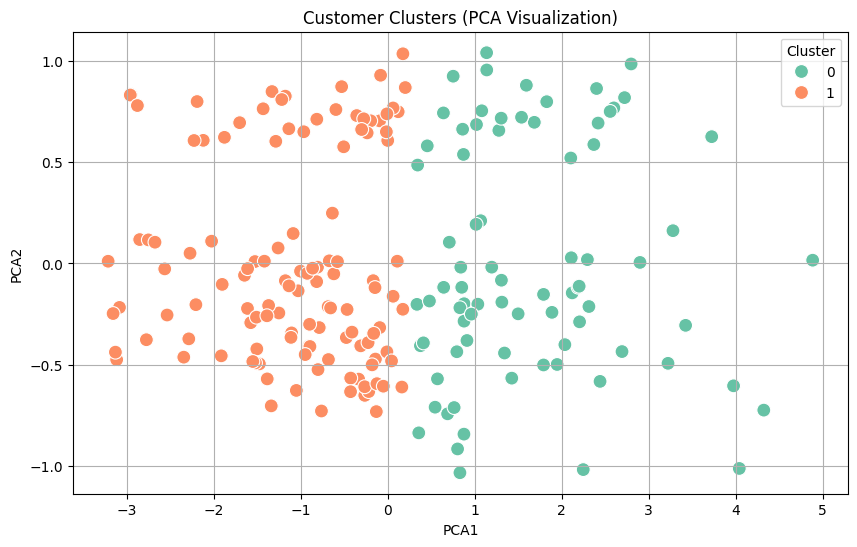

In [11]:
# Visualization using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)
customer_features['PCA1'] = pca_result[:, 0]
customer_features['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_features, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=100)
plt.title('Customer Clusters (PCA Visualization)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.grid()
plt.show()

In [12]:
# Save results
customer_features[['CustomerID', 'Cluster']].to_csv('Customer_Clusters.csv', index=False)
metrics_df = pd.DataFrame(cluster_metrics)
metrics_df.to_csv('Clustering_Metrics.csv', index=False)

print(f"Optimal number of clusters: {n_clusters}")
print(f"Clustering metrics saved to Clustering_Metrics.csv.")
print(f"Customer clusters saved to Customer_Clusters.csv.")

Optimal number of clusters: 2
Clustering metrics saved to Clustering_Metrics.csv.
Customer clusters saved to Customer_Clusters.csv.
